In [1]:
import os
import psycopg
import pandas as pd

TABLE_NAME = 'flats_clean_table'

os.environ["DB_DESTINATION_HOST"] = os.getenv("DB_DESTINATION_HOST")
os.environ["DB_DESTINATION_PORT"] = os.getenv("DB_DESTINATION_PORT")
os.environ["DB_DESTINATION_NAME"] = os.getenv("DB_DESTINATION_NAME")
os.environ["DB_DESTINATION_USER"] = os.getenv("DB_DESTINATION_USER")
os.environ["DB_DESTINATION_PASSWORD"] = os.getenv("DB_DESTINATION_PASSWORD")

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")


connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.environ["DB_DESTINATION_HOST"], 
    "port": os.environ["DB_DESTINATION_PORT"],
    "dbname": os.environ["DB_DESTINATION_NAME"],
    "user": os.environ["DB_DESTINATION_USER"],
    "password": os.environ["DB_DESTINATION_PASSWORD"],
}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, df['price'], test_size=0.2, random_state=42)


Previous model fit:

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error
import json

float_cols = df.select_dtypes(include='float').columns.to_list()
#all cat cols is yes/no cols
cat_cols = df.select_dtypes(include='object').columns.to_list()
preprocessor = ColumnTransformer(
    [
        ('num_cols_norm', StandardScaler(), float_cols),
        ('cat_cols_encode', OneHotEncoder(drop='if_binary'), cat_cols)
    ]
)
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)
pipeline.fit(X_train, y_train)
prediction = pipeline.predict(X_test)
metrics = {}
mae = mean_absolute_error(y_test, prediction)
r2 = r2_score(y_test, prediction)
metrics['mae'] = mae
metrics['r2'] = r2
with open('metrics.json', 'w') as f:
    json.dump(metrics, f)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, 
    SplineTransformer, 
    QuantileTransformer, 
    RobustScaler,
    PolynomialFeatures,
    KBinsDiscretizer,
)

num_columns = ['floor', 'kitchen_area', 'living_area', 'rooms',
               'total_area', 'price', 'build_year', 'building_type_int', 
               'latitude', 'longitude', 'ceiling_height', 'flats_count',
               'floors_total']
cat_columns = ['is_apartment','has_elevator']

encoder_oh = OneHotEncoder(categories='auto', handle_unknown='ignore', sparse_output=False, drop='first')
encoder_spl = SplineTransformer(n_knots=3, degree=4)
encoder_q = QuantileTransformer(n_quantiles=100)
encoder_rb = RobustScaler()
encoder_pol = PolynomialFeatures(degree=3)
encoder_kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', subsample=None)

transformer = ColumnTransformer(
  transformers=[
      ('encoder', encoder_oh, cat_columns),
      ('spl', encoder_spl, num_columns), 
      ('q', encoder_q, num_columns), 
      ('rb', encoder_rb, num_columns), 
      ('pol', encoder_pol, num_columns), 
      ('kbd', encoder_kbd, num_columns)
  ], n_jobs=-1
)

new_pipeline = Pipeline(
    [
        ('preprocessor', transformer),
        ('model', model)
    ]
)
new_pipeline.fit(X_train, y_train)
new_prediction = new_pipeline.predict(X_test)
new_metrics = {}
mae = mean_absolute_error(y_test, new_prediction)
r2 = r2_score(y_test, new_prediction)
new_metrics['mae'] = mae
new_metrics['r2'] = r2


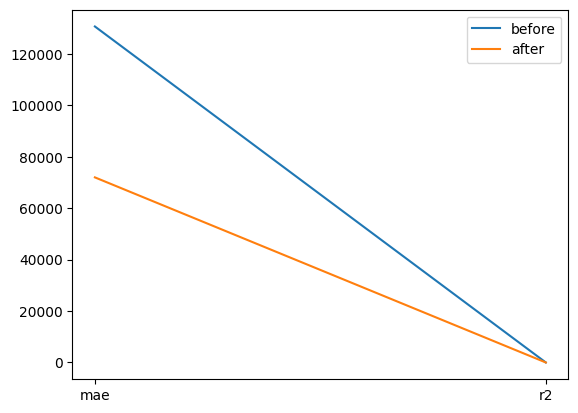

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

ASSETS_DIR = '../assets'
os.makedirs(ASSETS_DIR, exist_ok=True)

sns.lineplot(metrics, label='before')
sns.lineplot(new_metrics, label = 'after')
plt.savefig(os.path.join(ASSETS_DIR,'metrics_improvement'))